### Import Libraries

In [1]:
import numpy as np
import os
import torch
import cv2
from PIL import Image
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload
import model_architectures
import utilities

reload(model_architectures)
from model_architectures import VAE, Data3D

reload(utilities)
from utilities import get_colormaps

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

fig_dir = "paper_two_figures"

### Define Data

In [3]:
# Indices for train/val/test
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])


# Define Datasets
train = Data3D(l1_dir, train_indices)
val = Data3D(l1_dir, val_indices)
test = Data3D(l5_dir, test_indices)

AttributeError: 'AxesImage' object has no attribute 'axis'

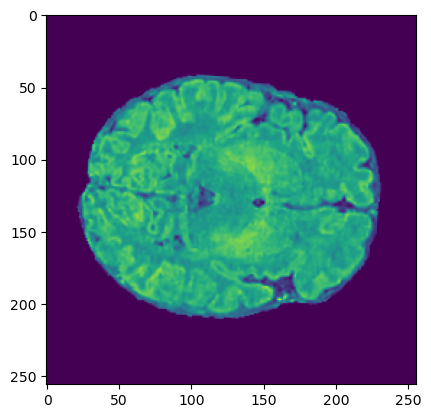

In [11]:
fig = plt.imshow(train[0][0, :,: , 128])
fig.axis('off')

### Helper Functions

In [4]:
model_options = {
    "T1 Only": {
        "weights": "vae_rel2_t1_second_session.pt",
        "model": VAE(1),
        "shape": (1, 1, 256, 256, 256)
    },
    "T2 Only": {
        "weights": "vae_rel2_t2_second_session.pt",
        "model": VAE(1),
        "shape": (1, 1, 256, 256, 256)
    },
    "Multimodal": {
        "weights": "vae_rel2_t1_t2_second_session.pt",
        "model": VAE(2),
        "shape": (1, 2, 256, 256, 256)
    },
}

def get_dataset(batch):
    if batch=="Train":
        return train
    elif batch=="Validation":
        return val
    else:
        return test

def load_model(config):
    model_path = os.path.join(model_dir, config["weights"])
    model = config["model"]
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()
    
    return model

def get_prediction(img):
    pred = model(torch.Tensor(np.reshape(img, config["shape"])).cuda())
    diff = img - np.reshape(pred.cpu().detach().numpy(), img.shape)
    
    if stdev_version == "Global":
        return diff / 0.1
    else:
        mean = np.mean(diff)
        stdev = np.std(diff)
        
        return (diff - mean) / stdev

def load_image(batch, subject):
    """Get subject images from correct batch."""
    data = get_dataset(batch)[int(subject)-1]
    
    t1 = np.stack((data[0],)*3, axis=-1)
    t1 = np.rot90(t1)
    t1 = np.concatenate((t1, np.ones((256, 256, 256, 1))), axis=3)
    
    
    t2 = np.stack((data[1],)*3, axis=-1)
    t2 = np.rot90(t2)
    t2 = np.concatenate((t2, np.ones((256, 256, 256, 1))), axis=3)
    
    if model_version == "T1 Only":
        norm = get_prediction(data[0])
        norm = np.rot90(norm)
    elif model_version == "T2 Only":
        norm = get_prediction(data[1])
        norm = np.rot90(norm)
    else:
        norm = get_prediction(data)
        norm = np.rot90(norm, axes=(1,2))
    
    return t1, t2, norm


def get_cluster_mask(array, min_cluster):
    cluster_map = array.copy()
    cluster_map[cluster_map != 0] = 1
    cluster_map = cluster_map.astype('uint8')
    
    _, labels = cv2.connectedComponents(cluster_map)
    values, counts = np.unique(labels, return_counts=True)
    labels[np.isin(labels, [x for x, y in zip(values, counts) if y < min_cluster])] = 0
    labels[labels != 0] = 1
    
    return labels

def get_overlay(diff):
    rounded = np.round(diff, 1)
    # Values that fall below the mean/threshold
    below_zero = rounded.copy()
    below_zero[below_zero > -threshold] = 0
    below_zero = np.clip(below_zero, -max_z, 0)
    
    # Values that fall above the mean/threshold
    above_zero = rounded.copy()
    above_zero[above_zero < threshold] = 0
    above_zero = np.clip(above_zero, 0, max_z)
    
    if filter_clusters:
        az_mask = get_cluster_mask(above_zero, cluster_size)
        above_zero *= az_mask
        
        bz_mask = get_cluster_mask(below_zero, cluster_size)
        below_zero *= bz_mask
    
    combined = np.zeros((*above_zero.shape, 4))
    for value, color in reds.items():
        combined[above_zero == value] = color
    for value, color in blues.items():
        combined[below_zero == value] = color
        
    return combined

def get_slice(img, norm, slice_number):
    image_pil = Image.fromarray(np.uint8(img[:,:,slice_number-1] * 255), mode="RGBA")

    overlay = get_overlay(norm[:,:,slice_number-1])
    overlay_pil = Image.fromarray(np.uint8(overlay * 255), mode="RGBA")

    return Image.alpha_composite(image_pil, overlay_pil)
    
max_z = 10
reds, blues = get_colormaps(max_z)
colorbar = Image.open("colorbar.png")

In [5]:
def get_banded_layer(az, az_mask, bz, bz_mask):
    az[np.invert(az_mask)] = 0
    bz[np.invert(bz_mask)] = 0
    comb = np.zeros((*az.shape, 4))
    for value, color in reds.items():
        comb[az == value] = color
    for value, color in blues.items():
        comb[bz == value] = color
        
    return comb

def get_banded_overlay_slice(img, norm, slice_number):
    image_pil = Image.fromarray(np.uint8(img[:,:,slice_number-1] * 255), mode="RGBA")

    rounded = np.round(norm[:,:,slice_number-1], 1)
    # Values that fall below the mean/threshold
    below_zero = rounded.copy()
    below_zero[below_zero > -threshold] = 0
    below_zero = np.clip(below_zero, -max_z, 0)

    # Values that fall above the mean/threshold
    above_zero = rounded.copy()
    above_zero[above_zero < threshold] = 0
    above_zero = np.clip(above_zero, 0, max_z)

    # 4 to inf
    high_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 4) & (above_zero < np.inf)),
        below_zero.copy(),
        ((below_zero > -np.inf) & (below_zero <= -4))
    )
    medium_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 3) & (above_zero < 4)),
        below_zero.copy(),
        ((below_zero > -4) & (below_zero <= -3))
    )
    low_band = get_banded_layer(
        above_zero.copy(),
        ((above_zero >= 2) & (above_zero < 3)),
        below_zero.copy(),
        ((below_zero > -3) & (below_zero <= -2))
    )

    # overlay = get_overlay(norm[:,:,slice_number-1])
    high_pil = Image.fromarray(np.uint8(high_band * 255), mode="RGBA")
    medium_pil = Image.fromarray(np.uint8(medium_band * 255), mode="RGBA")
    low_pil = Image.fromarray(np.uint8(low_band * 255), mode="RGBA")

    high_overlay = Image.alpha_composite(image_pil, high_pil)
    medium_overlay = Image.alpha_composite(image_pil, medium_pil)
    low_overlay = Image.alpha_composite(image_pil, low_pil)
    
    return high_overlay, medium_overlay, low_overlay

### Banded Approach

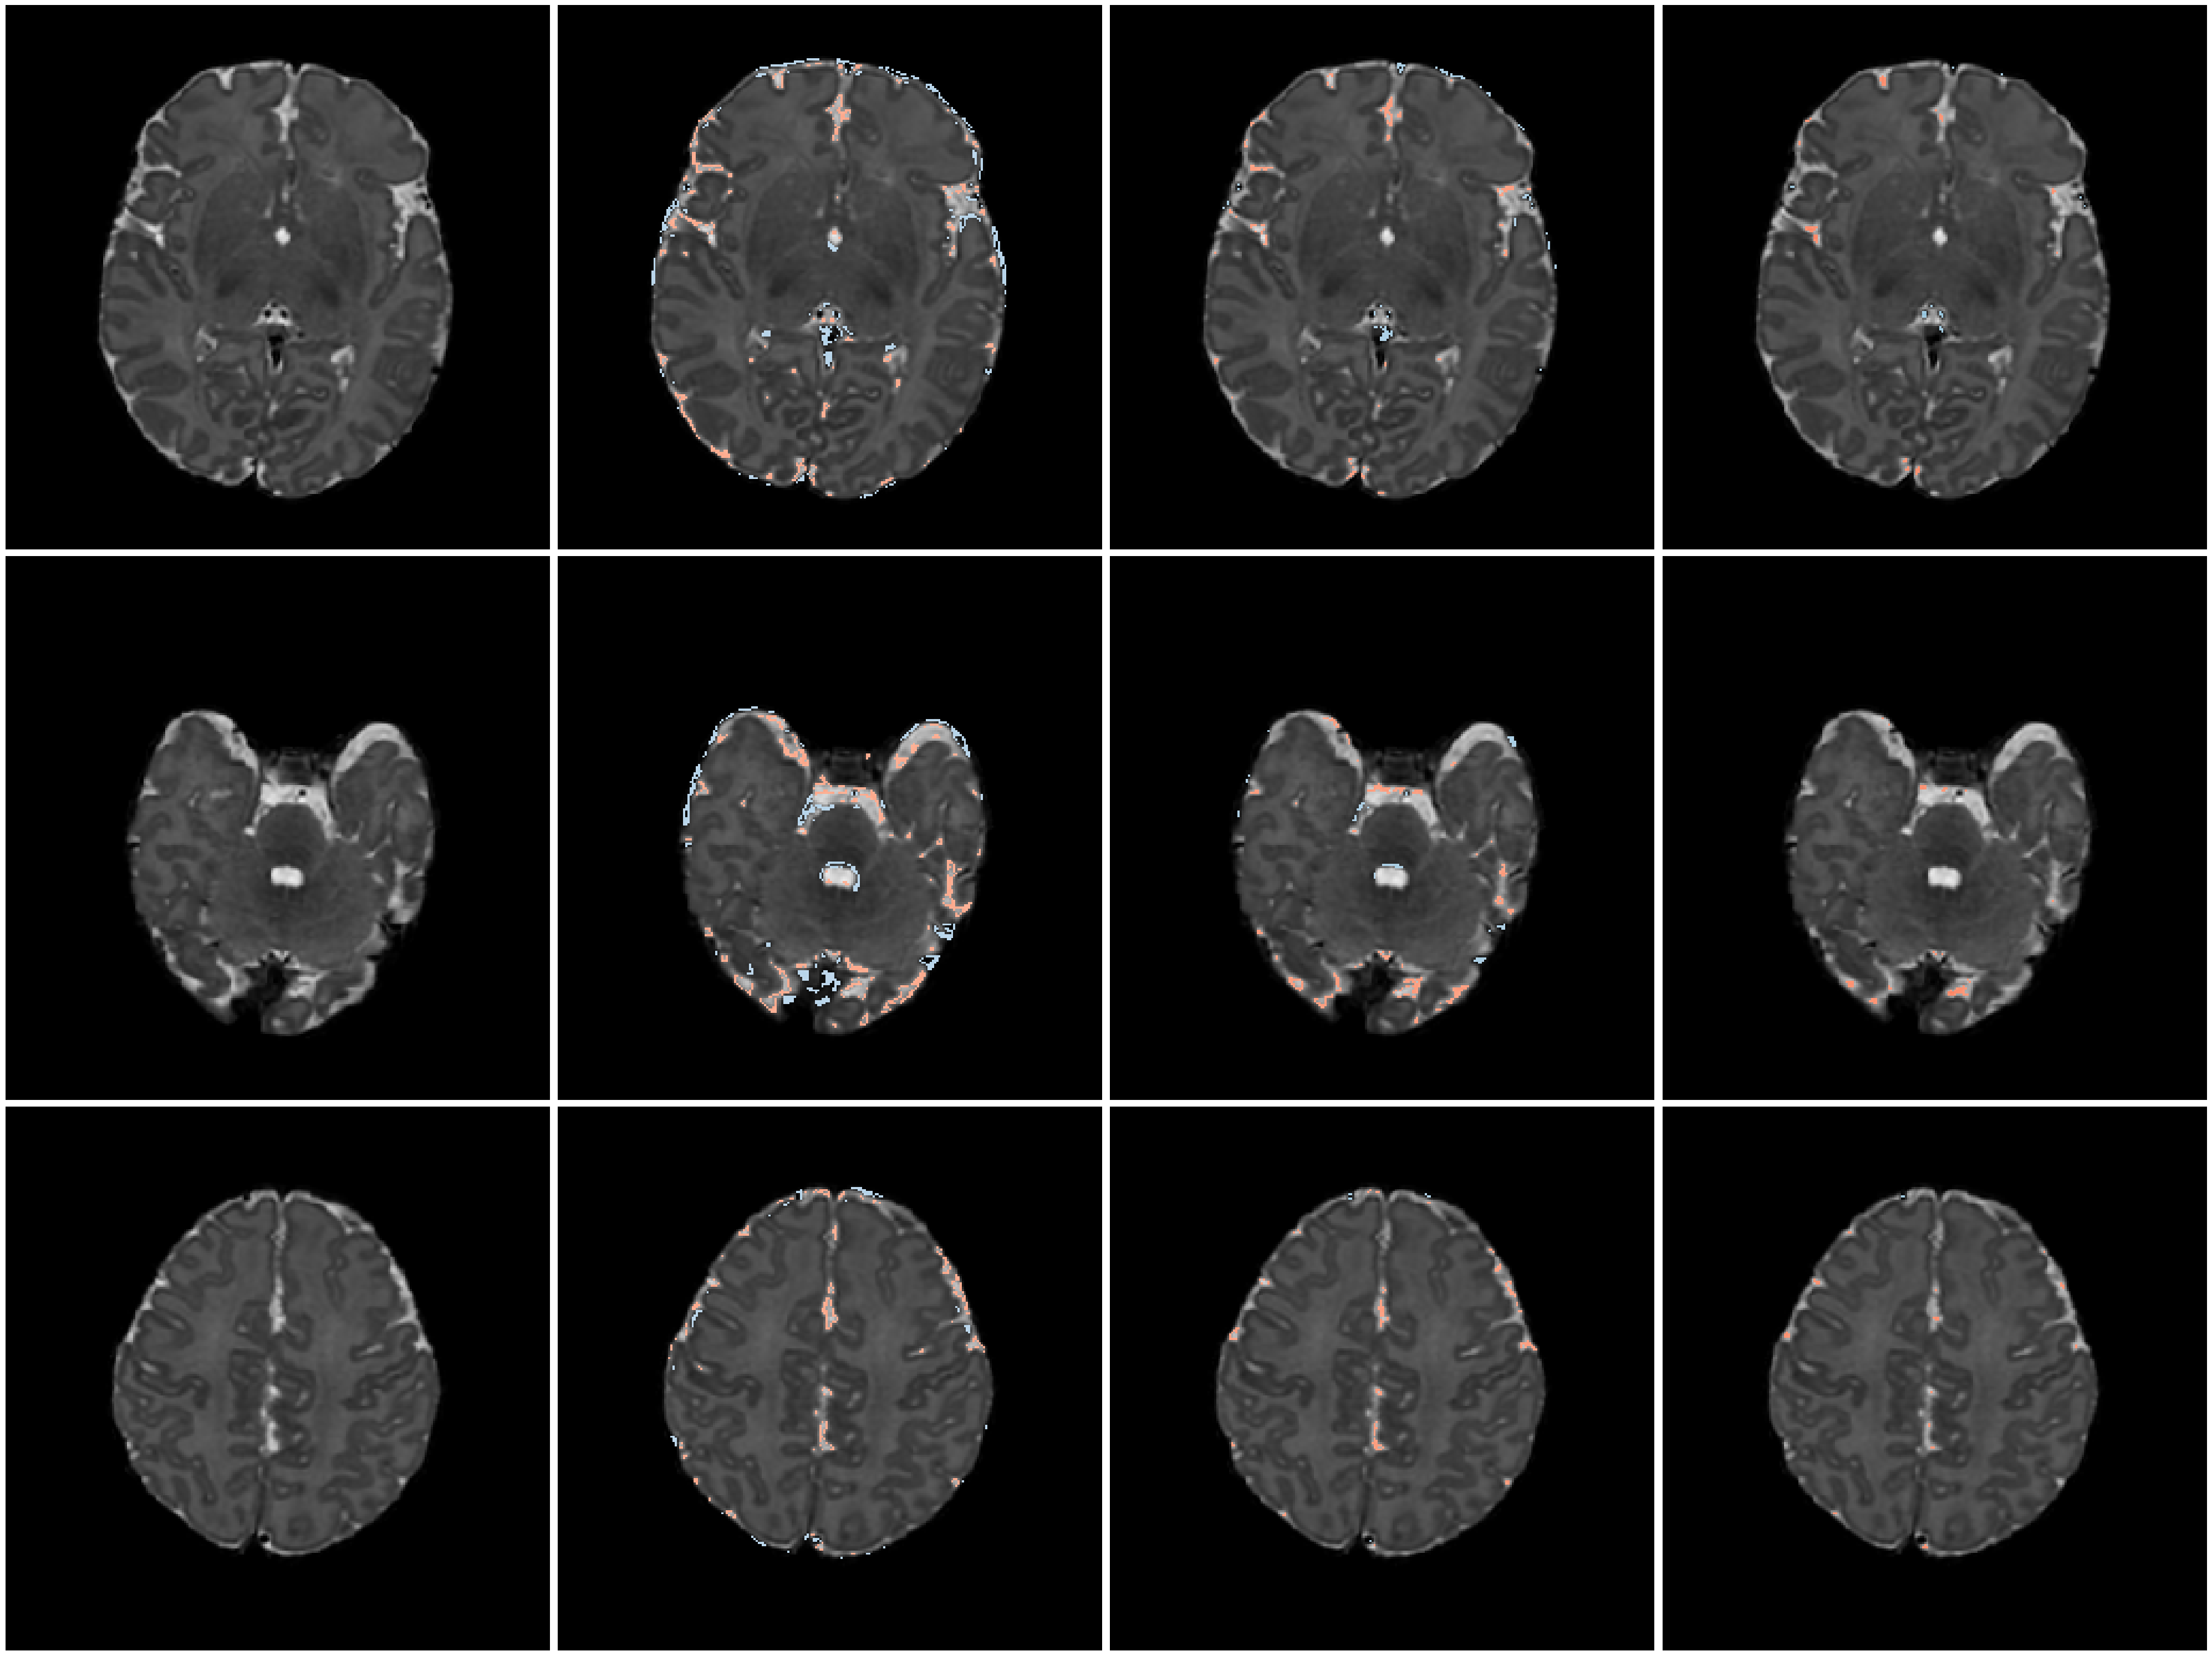

In [6]:
model_version = "Multimodal"
stdev_version = "Global"
config = model_options[model_version]
model = load_model(config)
t1, t2, norm = load_image("Train", 1)
threshold = 2
filter_clusters = False

img = t2.copy()
diff = norm[1].copy()

sup_idx, mid_idx, inf_idx = (64, 128, 192)

mid_high, mid_medium, mid_low = get_banded_overlay_slice(img, diff, mid_idx)
sup_high, sup_medium, sup_low = get_banded_overlay_slice(img, diff, sup_idx)
inf_high, inf_medium, inf_low = get_banded_overlay_slice(img, diff, inf_idx)

fig, ax = plt.subplots(3, 4, figsize=(40, 30))

ax[0][0].imshow(img[:,:,mid_idx])
ax[0][1].imshow(mid_low) 
ax[0][2].imshow(mid_medium)
ax[0][3].imshow(mid_high)

ax[1][0].imshow(img[:,:,sup_idx])
ax[1][1].imshow(sup_low) 
ax[1][2].imshow(sup_medium)
ax[1][3].imshow(sup_high)

ax[2][0].imshow(img[:,:,inf_idx])
ax[2][1].imshow(inf_low) 
ax[2][2].imshow(inf_medium)
ax[2][3].imshow(inf_high)

for v in ax:
    for w in v:
        w.axis('off')

fig.tight_layout()

### Normal for Paper

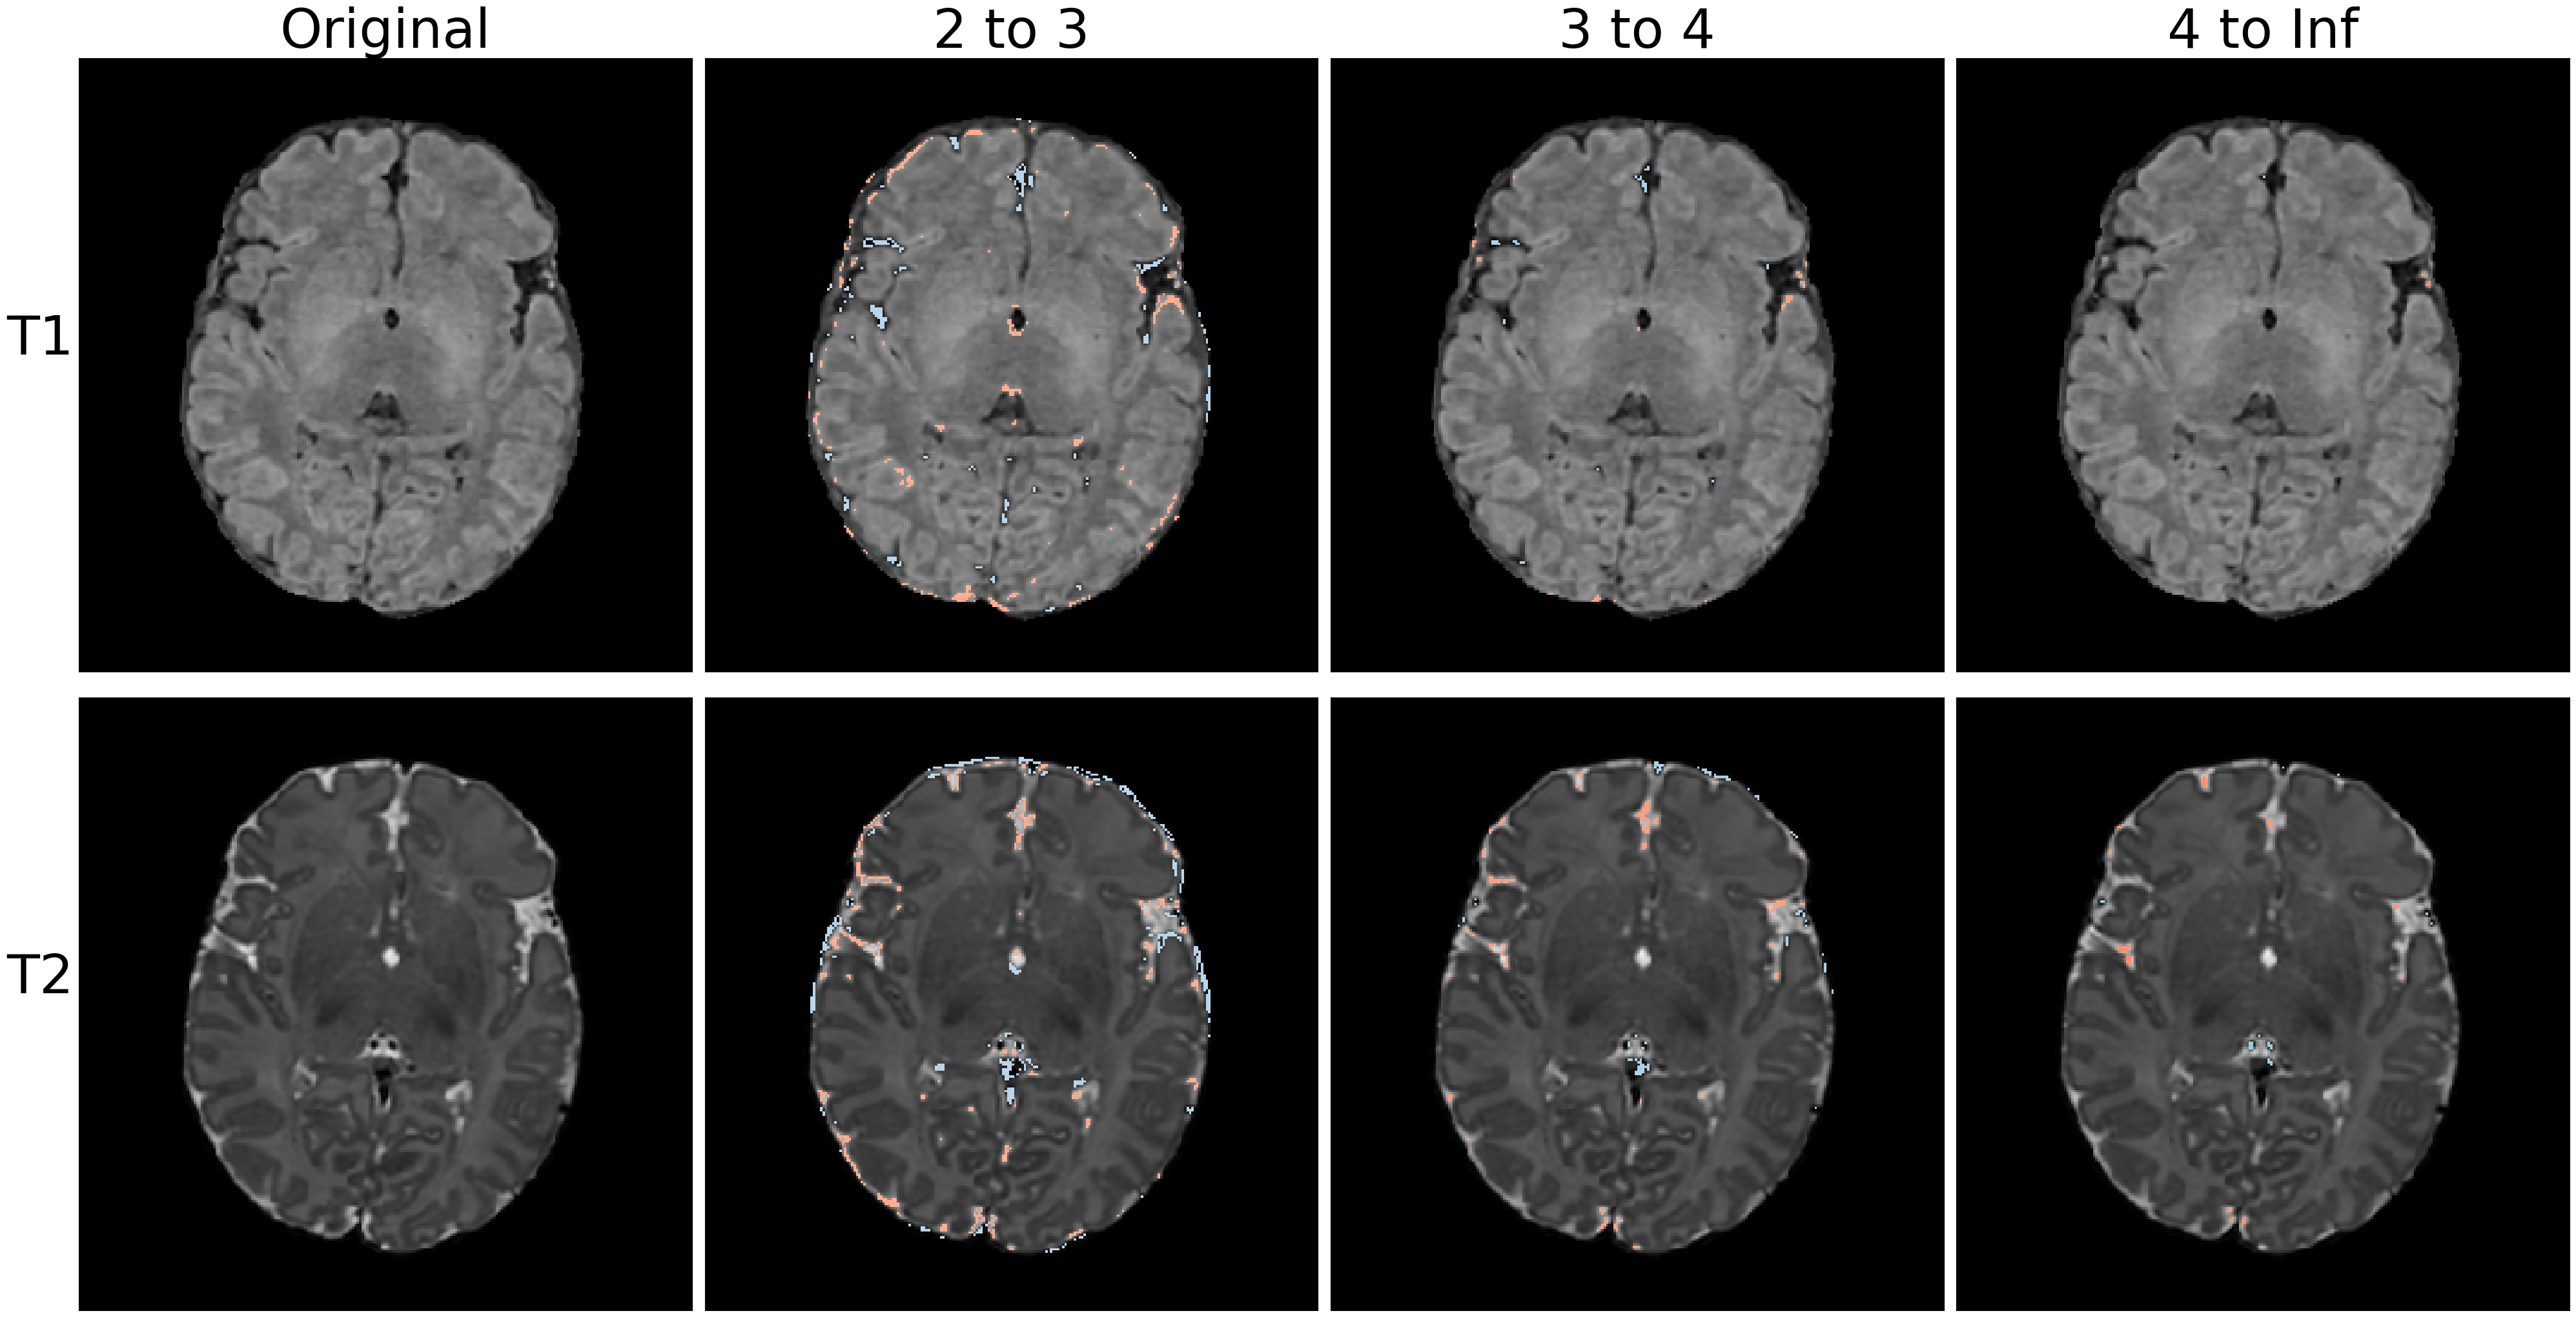

In [11]:
model_version = "Multimodal"
stdev_version = "Global"
config = model_options[model_version]
model = load_model(config)
t1, t2, norm = load_image("Train", 1)
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(t1, norm[0], mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(t2, norm[1], mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(t1[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(t2[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "multimodal_banded_normal.png"), dpi=72)

### Clinical Interpretation for Normal

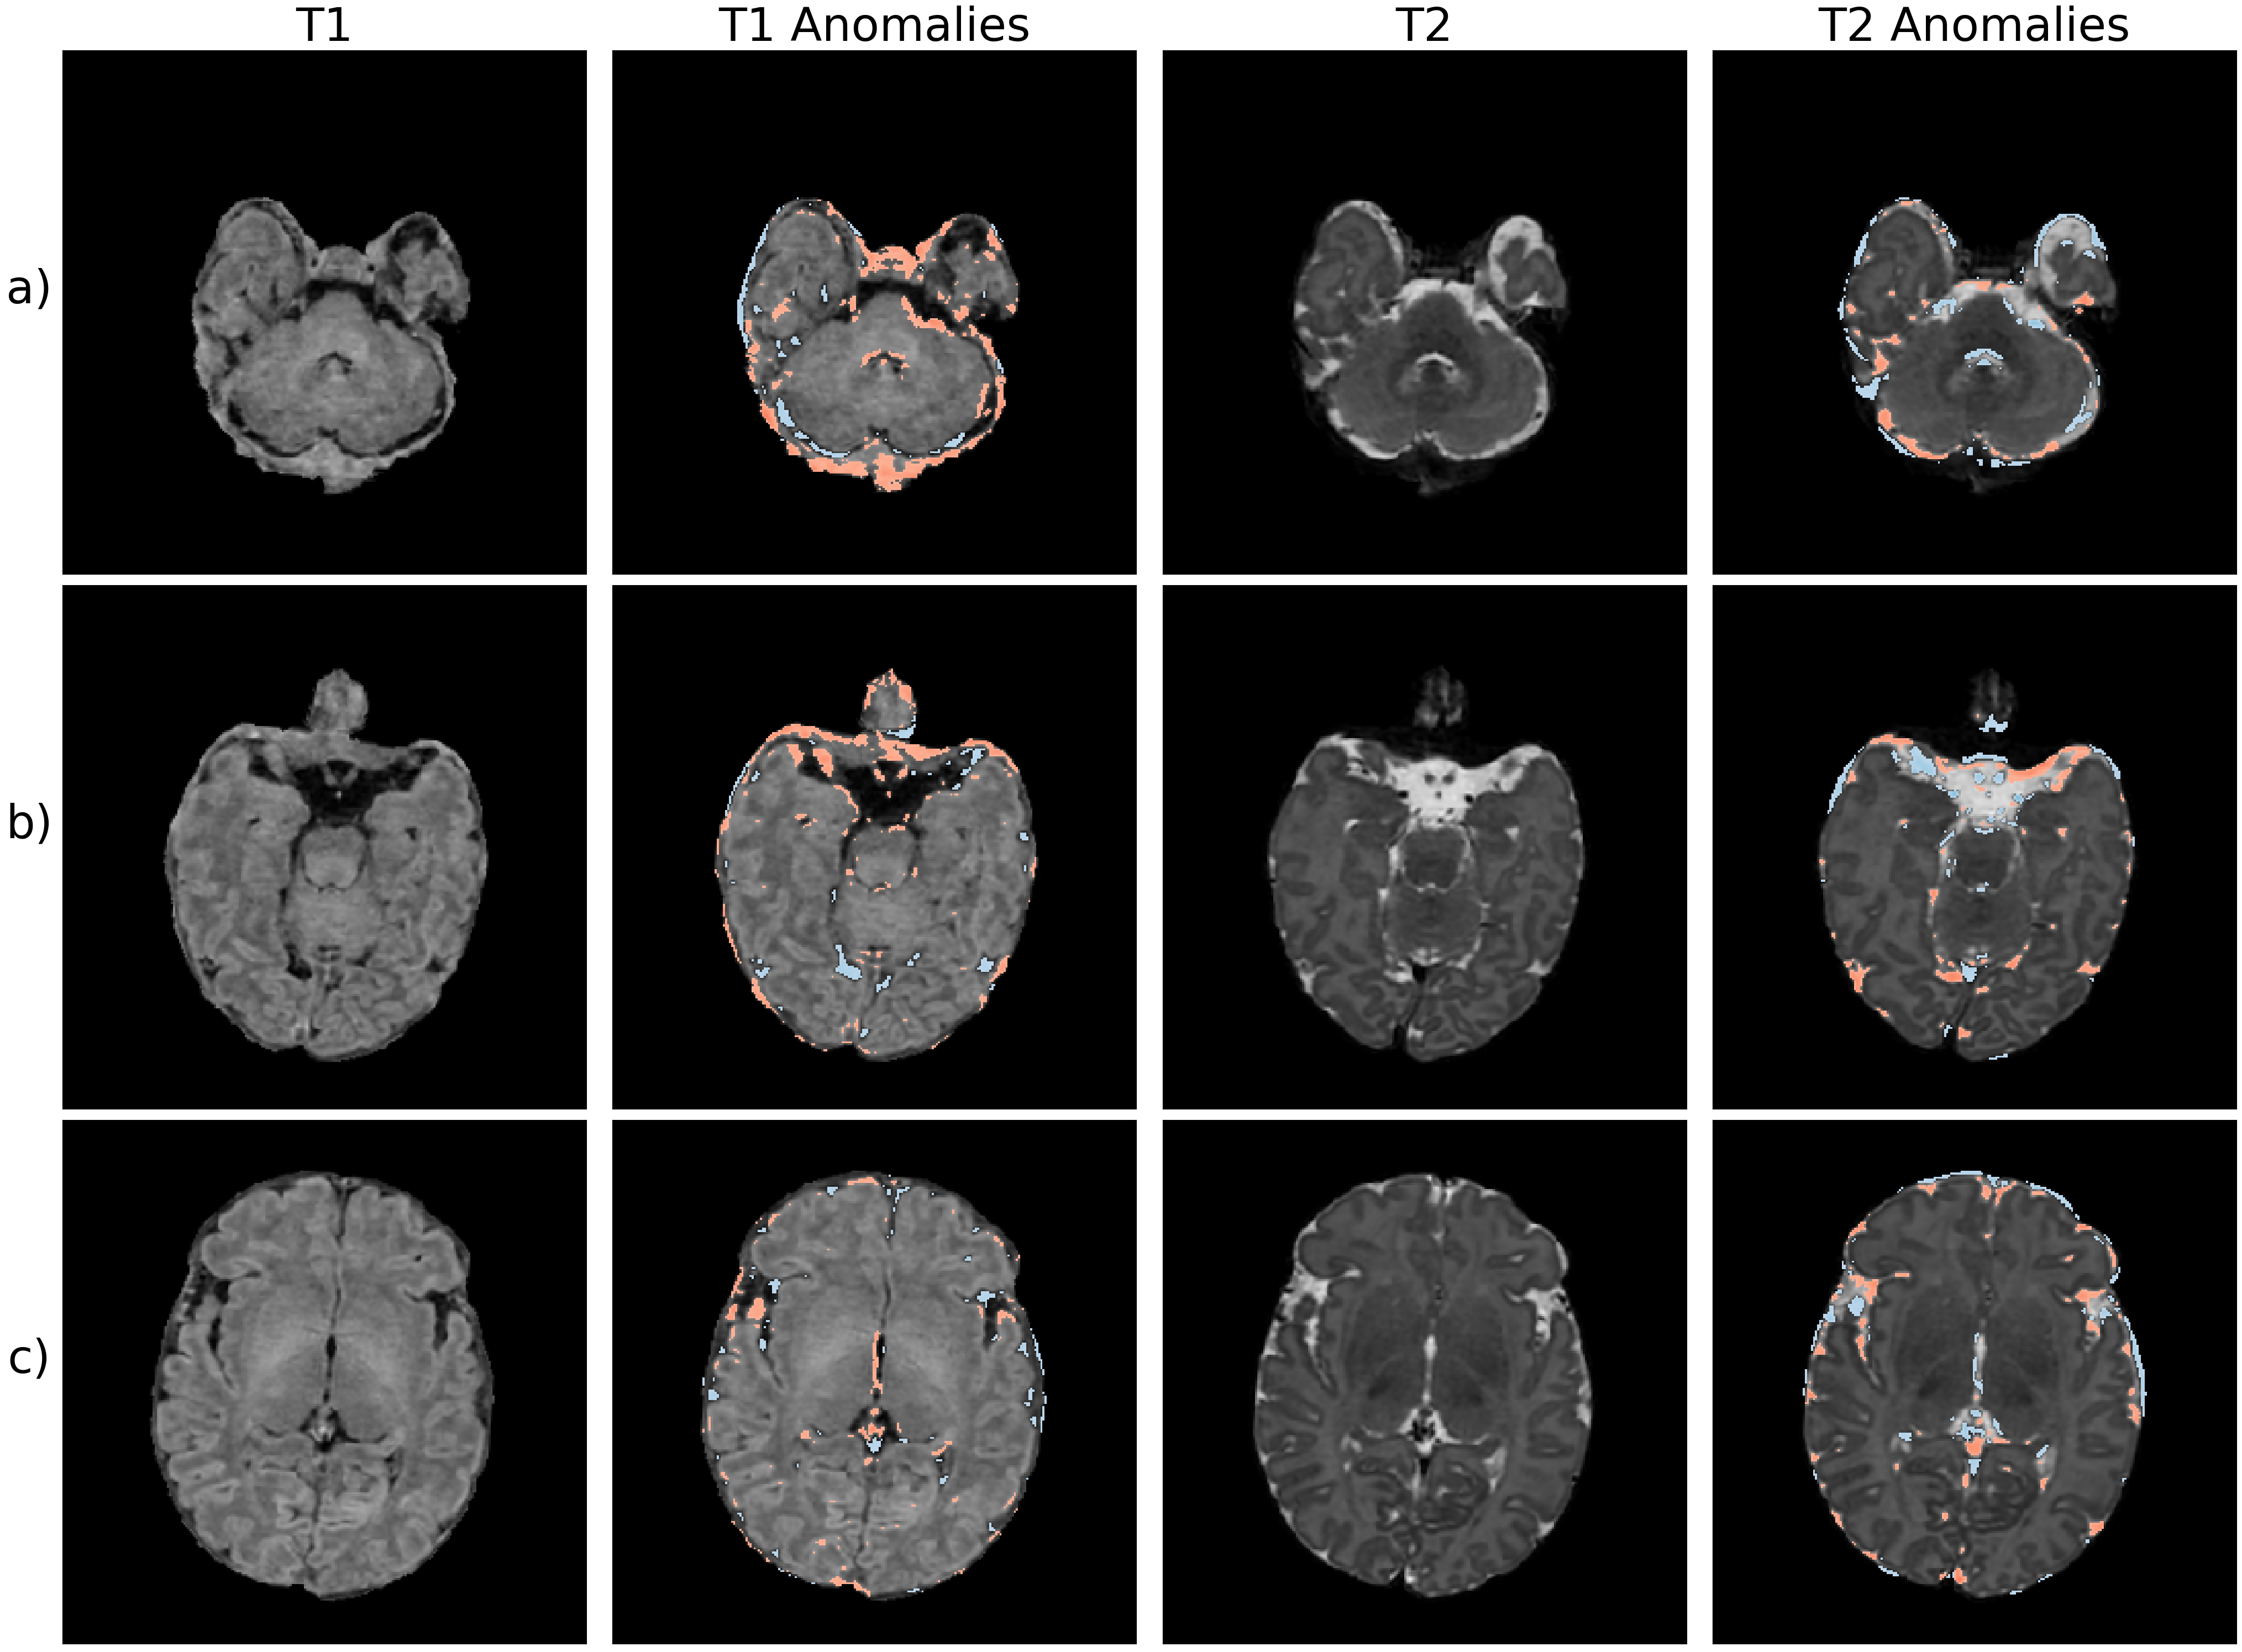

In [13]:
abi = {
    54:	"Threshold of 4.5 to decrease overlay signal from normal areas It still picks up fluid along the peiphery and normal areas at the periphery variability in CSF fluid space is it picking up variation in sulcation. This is most pronounced in posterior fossa and tmporal fossa",
    80:	"Interesting  at lower threshold below 5 picks u iptic nerves coursing through fluid space Did that further down with Trigeminal nerves Again the overlay sinal is mainly fluid spaces in and aro",
    # 114: "Threshold 25  3 works now Picks up the nerves pituitary stalk in the fluid spaces",
    120: "pineal signal seen again  as expected with variability. There is a lot of variability in pineal region with fluid filled cyst vessels so not a surprise that there is overlay signal in this region",
    # 134: "Threshold may be set above 35 to decrease noise in parenchyma along the periphery and around ventricle interface with fluid",
    # 249: "Just as in posterior fossa increase overlay signal in fluid spaces at the vertex  ie the beging and end slices"
}


num_slices = len(abi.keys())

fig, ax = plt.subplots(num_slices, 4, figsize=(41, num_slices * 10))

for idx, slc in enumerate(sorted(abi.keys())):
    ax[idx][0].imshow(t1[:,:,slc])
    ax[idx][1].imshow(get_slice(t1, norm[0], slc))
    ax[idx][2].imshow(t2[:,:,slc])
    ax[idx][3].imshow(get_slice(t2, norm[1], slc))

for v in ax:
    for w in v:
        # w.axis('off')
        # w.set_yticklabels([])
        # w.set_xticklabels([])
        w.set_yticks([])
        w.set_xticks([])

for a, col in zip(ax[0], ["T1", "T1 Anomalies", "T2", "T2 Anomalies"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], [f"{x})" for x in "abcdefg"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "multimodal_normal_clinical.png"), dpi=72)




### Banded Abnormal for Paper

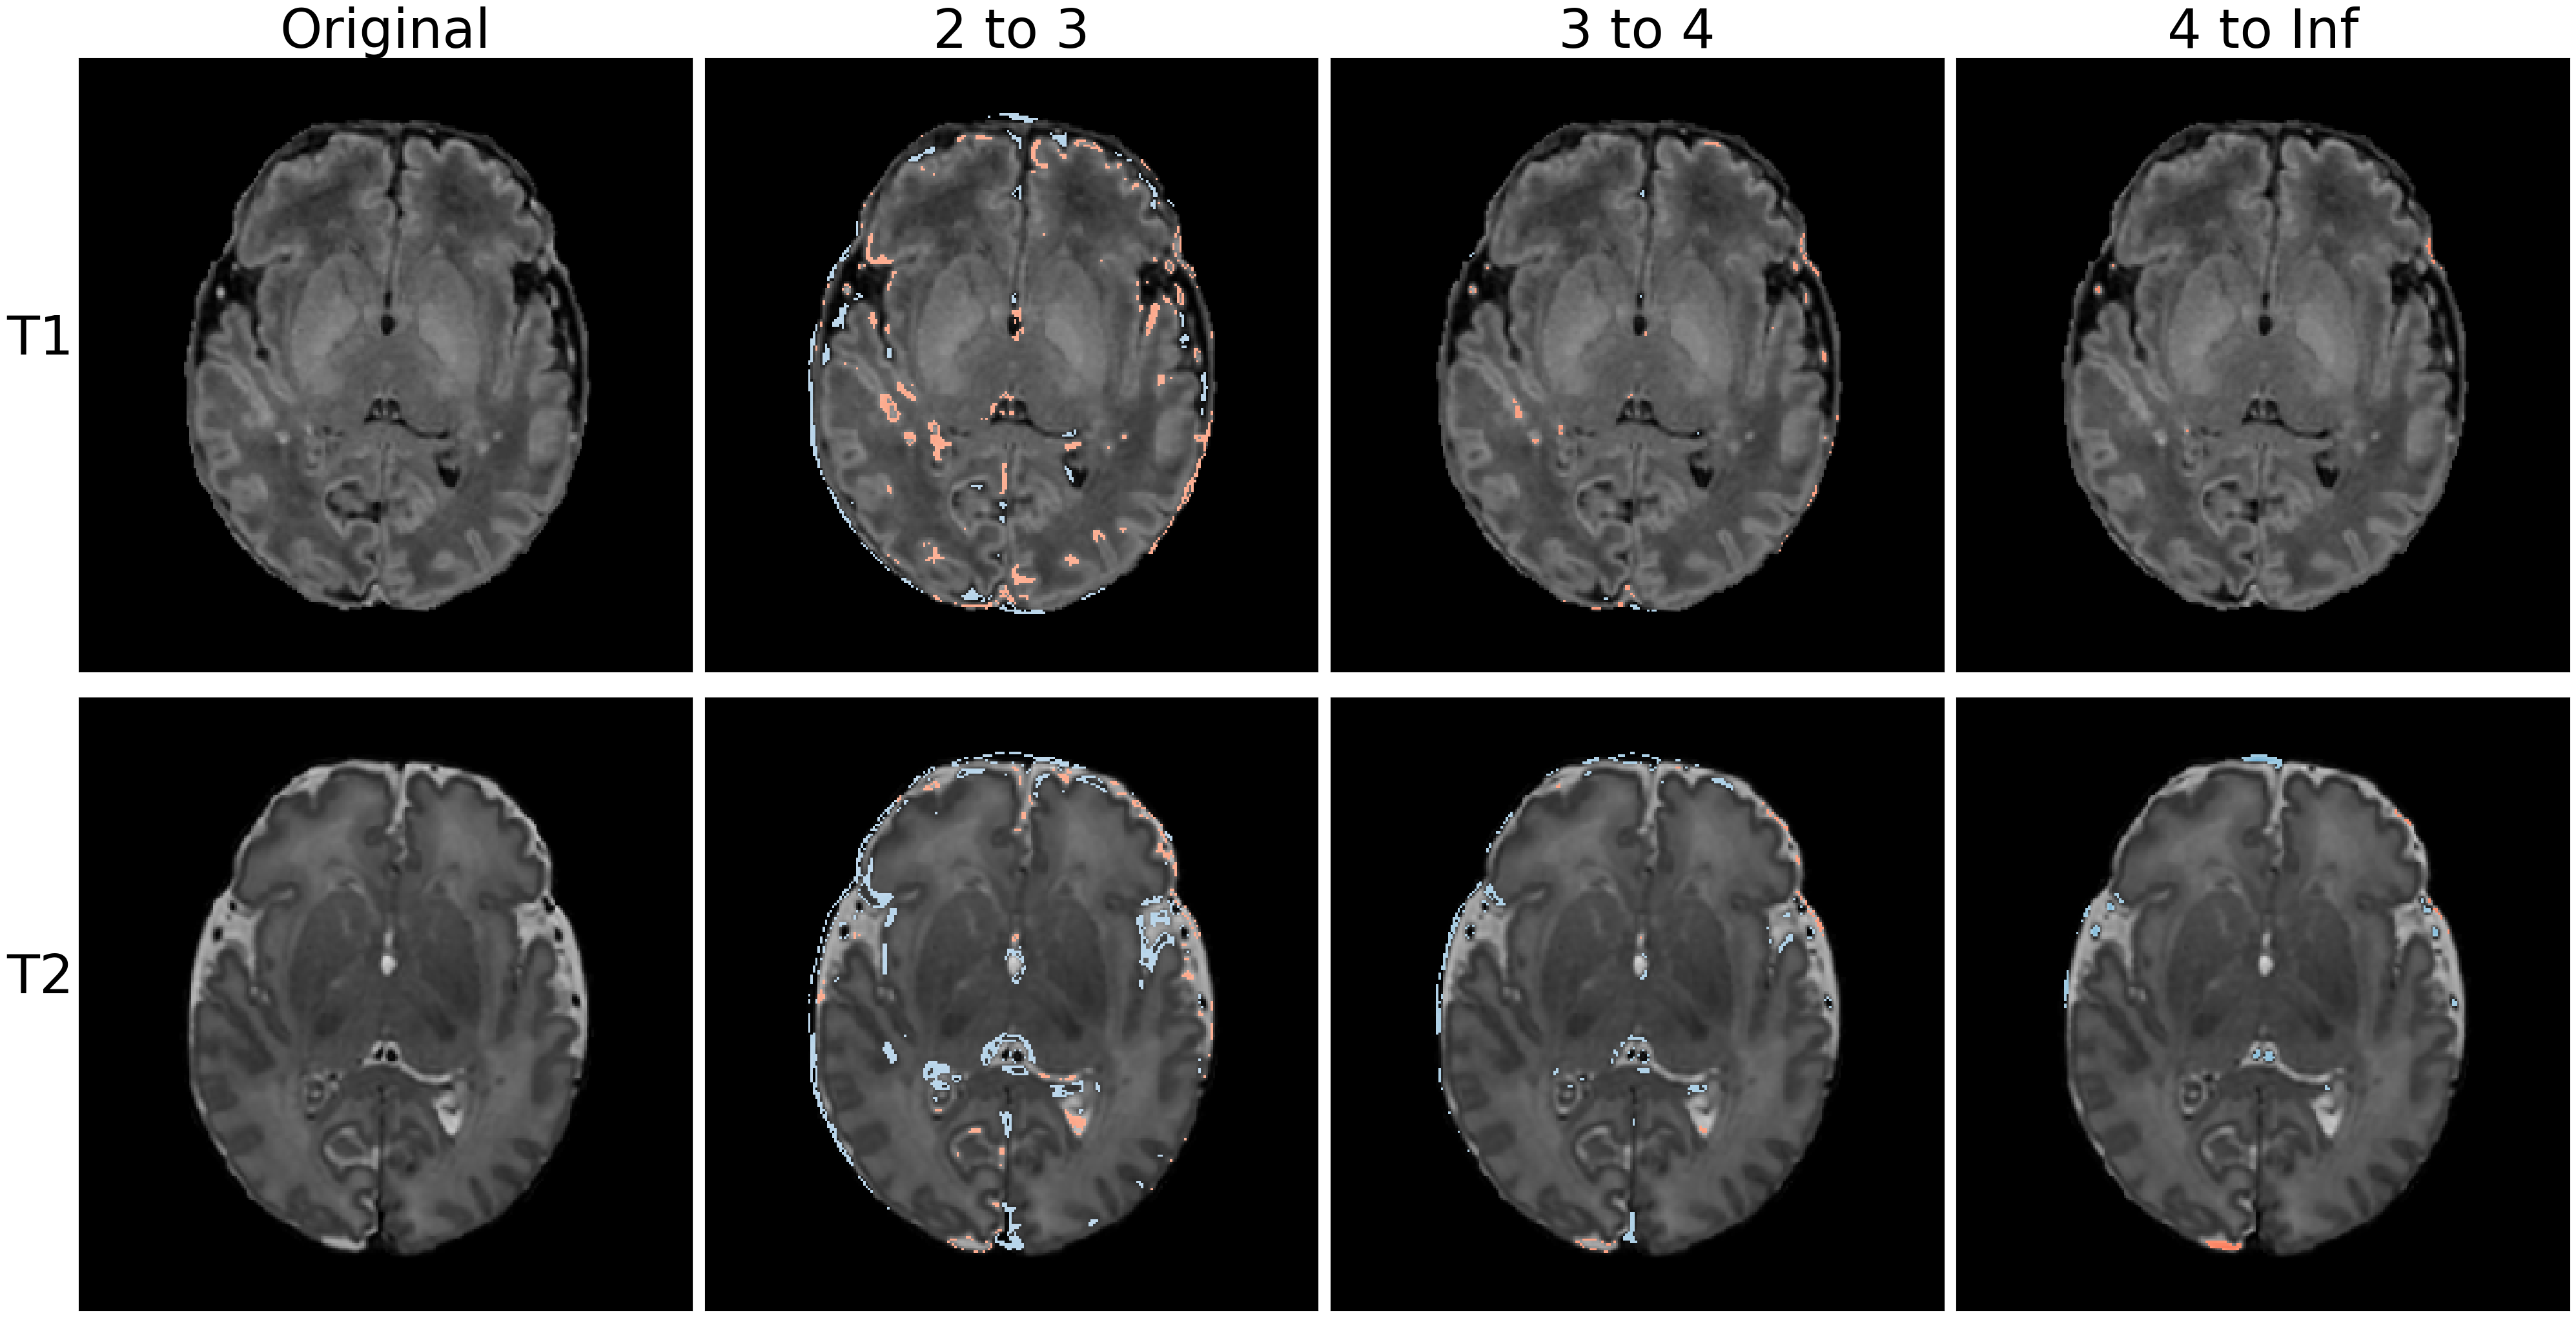

In [11]:
model_version = "Multimodal"
stdev_version = "Global"
config = model_options[model_version]
model = load_model(config)
t1, t2, norm = load_image("Test", 2)
threshold = 2
filter_clusters = False

mid_idx = 128

t1_high, t1_medium, t1_low = get_banded_overlay_slice(t1, norm[0], mid_idx)
t2_high, t2_medium, t2_low = get_banded_overlay_slice(t2, norm[1], mid_idx)

fig, ax = plt.subplots(2, 4, figsize=(40, 21))

ax[0][0].imshow(t1[:,:,mid_idx])
ax[0][1].imshow(t1_low) 
ax[0][2].imshow(t1_medium)
ax[0][3].imshow(t1_high)

ax[1][0].imshow(t2[:,:,mid_idx])
ax[1][1].imshow(t2_low) 
ax[1][2].imshow(t2_medium)
ax[1][3].imshow(t2_high)

for v in ax:
    for w in v:
        # w.axis('off')
        w.set_yticks([])
        w.set_xticks([])
        
for a, col in zip(ax[0], ["Original", "2 to 3", "3 to 4", "4 to Inf"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], ["T1", "T2"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "multimodal_banded_abnormal.png"), dpi=72)

### Clinical Interpretation for Abnormal

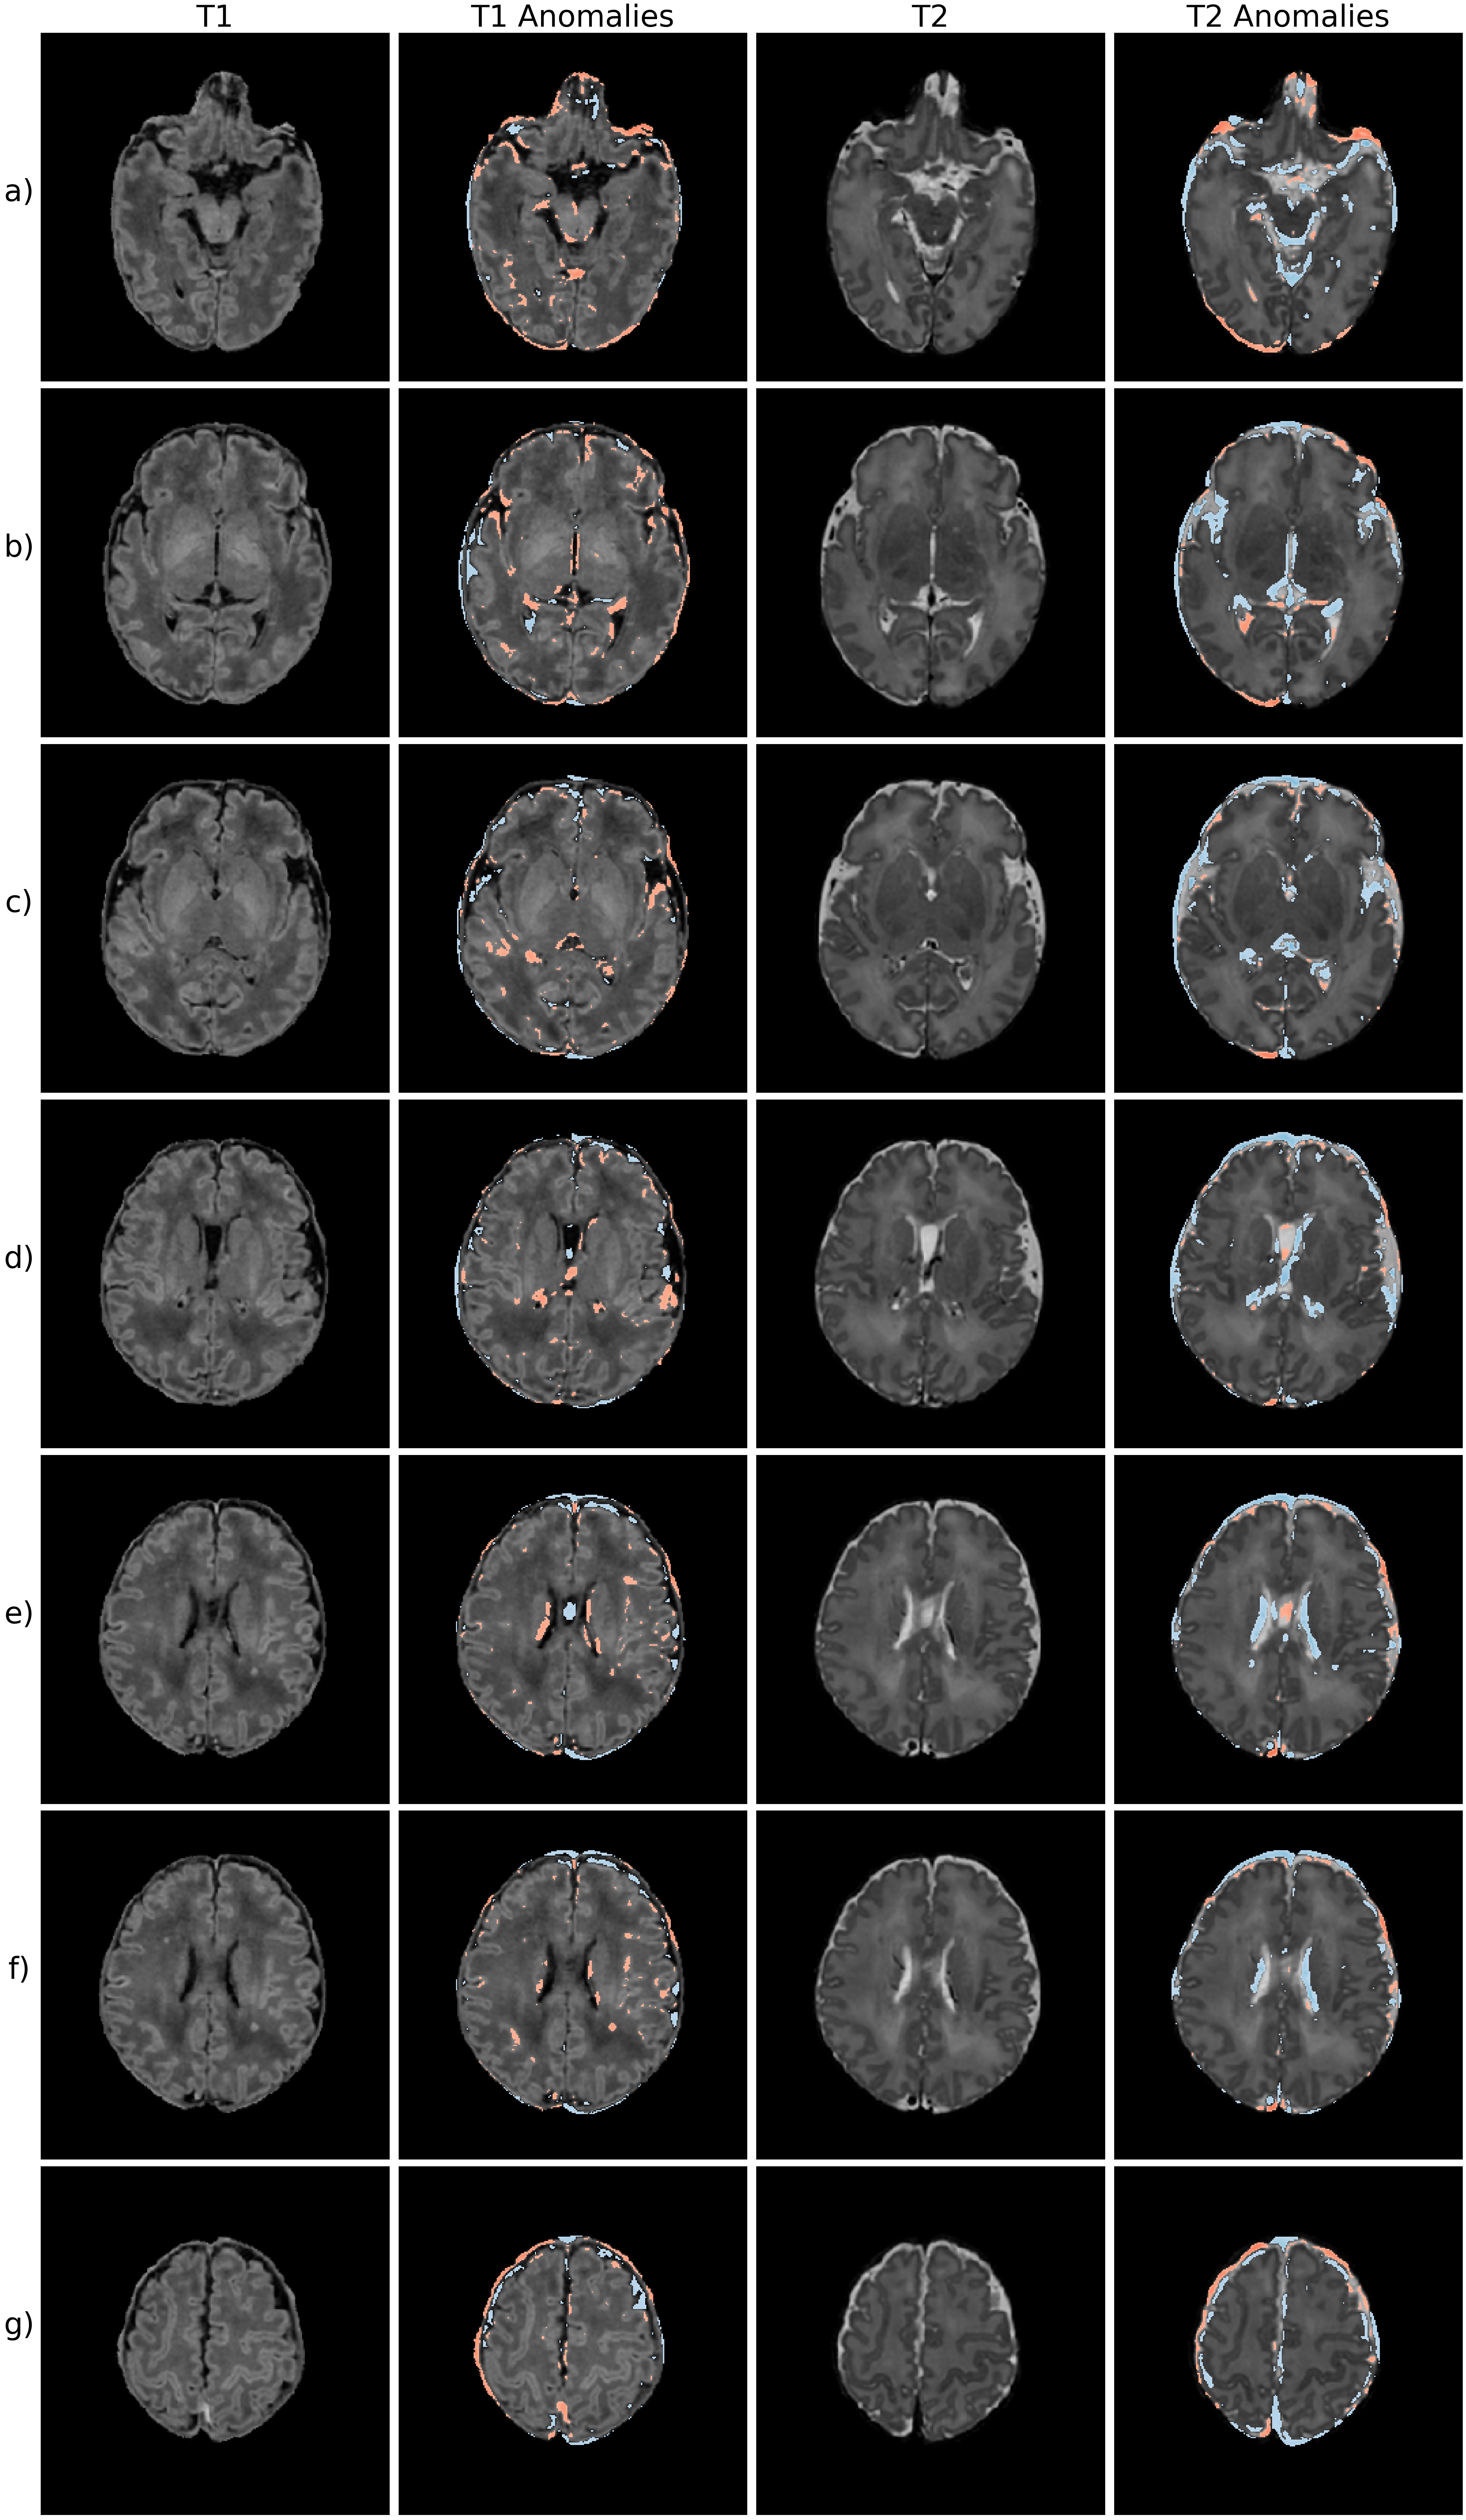

In [12]:
abi = {
    91: "picks up T1 bright minimal extraaxial hemorrhage",
    117: "picks up the T1 bright slightly T2 dark subthalamic signal on ly at threshold of 15 Marker for mild HIE",
    132: "picks abnormal right periventricular signal but not left",
    154: "signal in ventricle may be artifact or hemorrhage",
    166: "picks up slow flow vessels periventricular region left and right T2",
    168: "recognizes left abnormal white matter signal but not right frontal",
    209: "picks up bright signal T1 midline posterior  hemorrhage"
}

num_slices = len(abi.keys())

fig, ax = plt.subplots(num_slices, 4, figsize=(41, num_slices * 10))

for idx, slc in enumerate(sorted(abi.keys())):
    ax[idx][0].imshow(t1[:,:,slc])
    ax[idx][1].imshow(get_slice(t1, norm[0], slc))
    ax[idx][2].imshow(t2[:,:,slc])
    ax[idx][3].imshow(get_slice(t2, norm[1], slc))

for v in ax:
    for w in v:
        # w.axis('off')
        # w.set_yticklabels([])
        # w.set_xticklabels([])
        w.set_yticks([])
        w.set_xticks([])

for a, col in zip(ax[0], ["T1", "T1 Anomalies", "T2", "T2 Anomalies"]):
    a.set_title(col, fontsize=60)

for a, row in zip(ax[:,0], [f"{x})" for x in "abcdefg"]):
    a.set_ylabel(row, rotation=0, fontsize=60, labelpad=40)

fig.tight_layout()

fig.savefig(os.path.join(fig_dir, "multimodal_abnormal.png"), dpi=72)

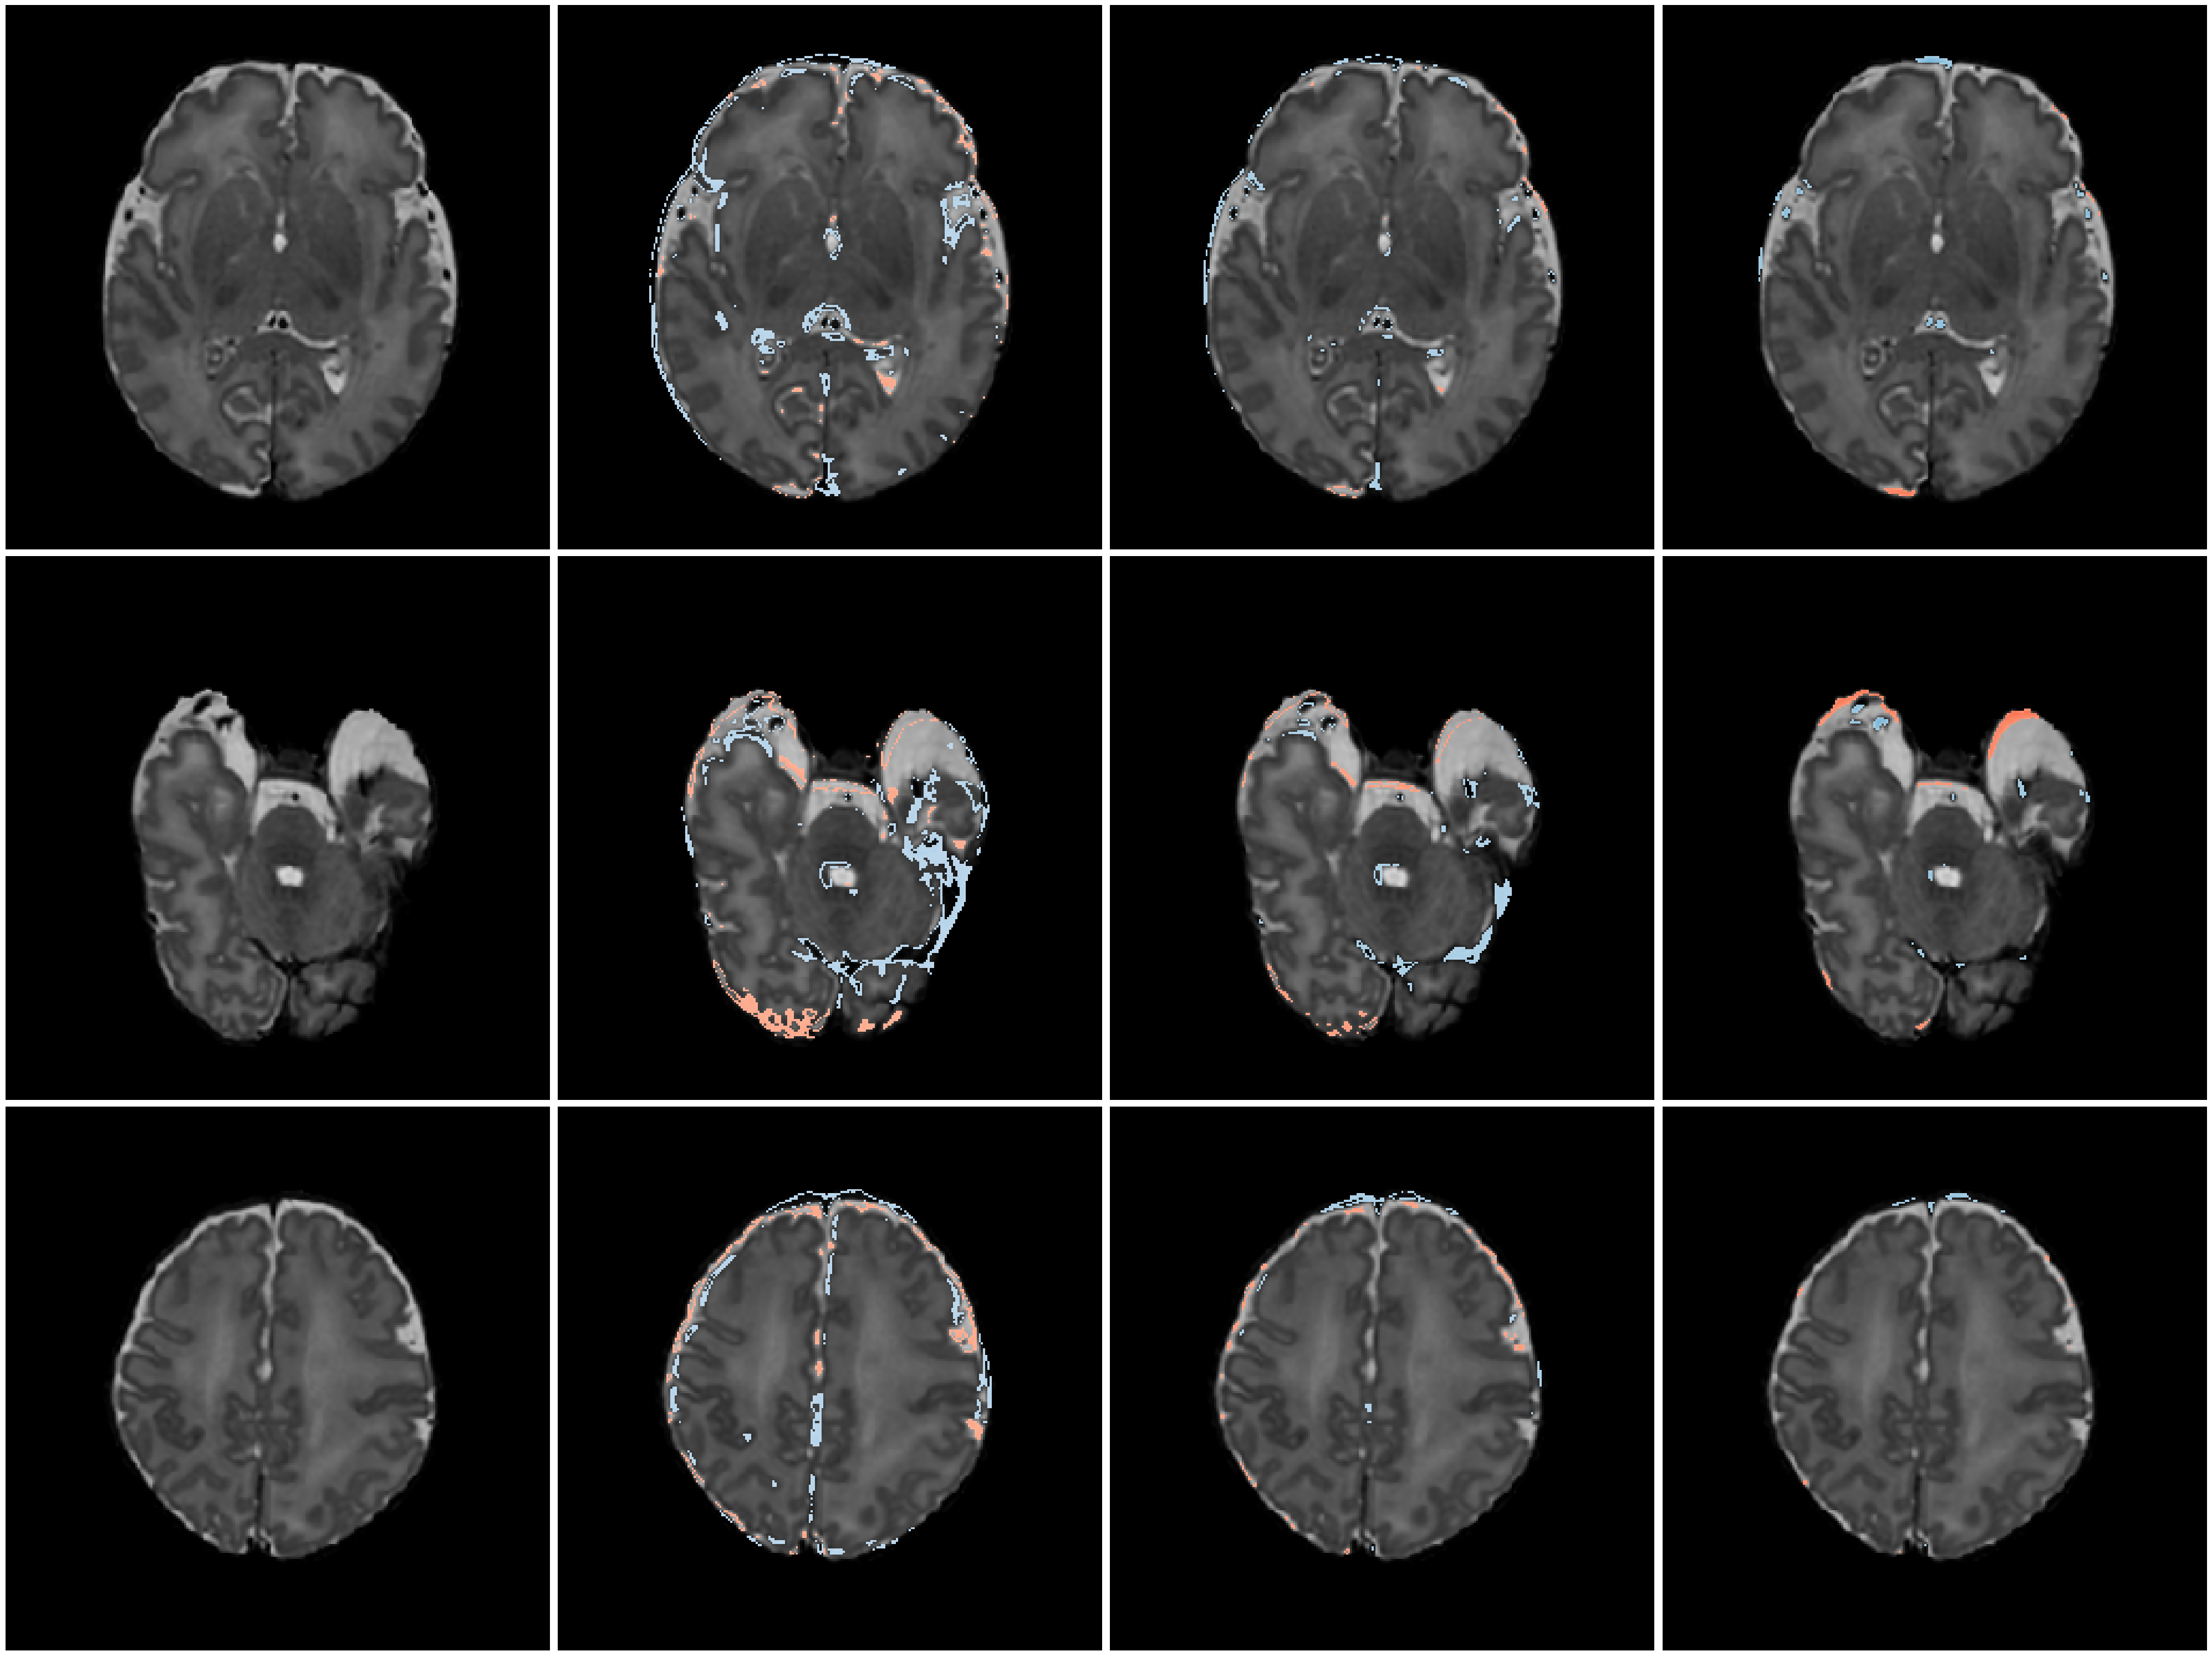

In [15]:
model_version = "Multimodal"
stdev_version = "Global"
config = model_options[model_version]
model = load_model(config)
t1, t2, norm = load_image("Test", 2)

threshold = 2
filter_clusters = False

img = t2.copy()
diff = norm[1].copy()

sup_idx, mid_idx, inf_idx = (64, 128, 192)

mid_high, mid_medium, mid_low = get_banded_overlay_slice(img, diff, mid_idx)
sup_high, sup_medium, sup_low = get_banded_overlay_slice(img, diff, sup_idx)
inf_high, inf_medium, inf_low = get_banded_overlay_slice(img, diff, inf_idx)

fig, ax = plt.subplots(3, 4, figsize=(40, 30))

ax[0][0].imshow(img[:,:,mid_idx])
ax[0][1].imshow(mid_low) 
ax[0][2].imshow(mid_medium)
ax[0][3].imshow(mid_high)

ax[1][0].imshow(img[:,:,sup_idx])
ax[1][1].imshow(sup_low) 
ax[1][2].imshow(sup_medium)
ax[1][3].imshow(sup_high)

ax[2][0].imshow(img[:,:,inf_idx])
ax[2][1].imshow(inf_low) 
ax[2][2].imshow(inf_medium)
ax[2][3].imshow(inf_high)

for v in ax:
    for w in v:
        w.axis('off')

fig.tight_layout()

### For T1 Only

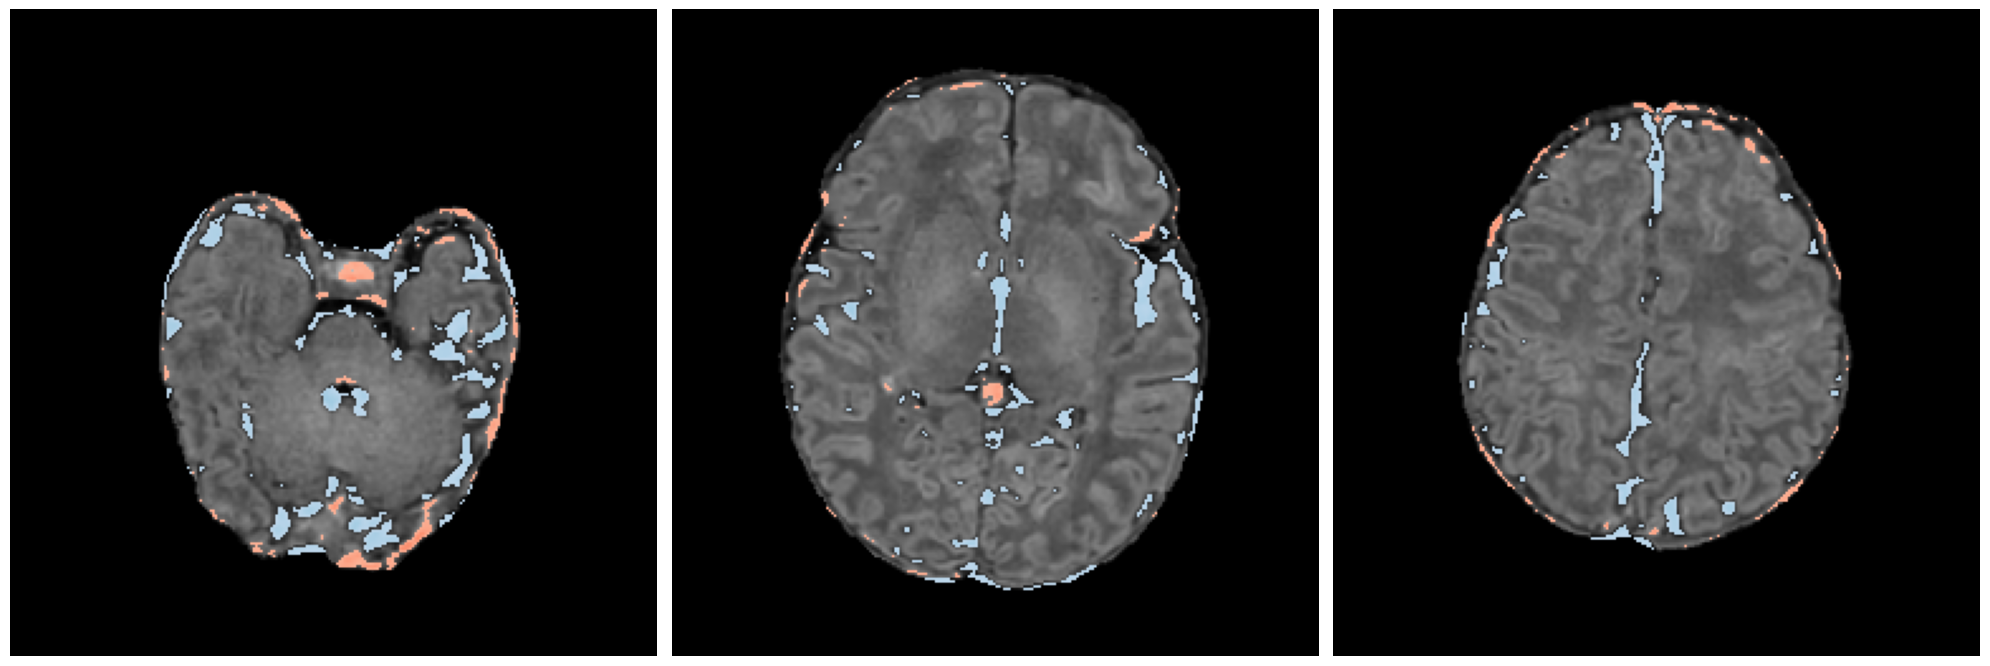

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].imshow(get_slice(t1, norm, 64)) 
ax[1].imshow(get_slice(t1, norm, 128))
ax[2].imshow(get_slice(t1, norm, 192))

for v in ax:
    v.axis('off')
    
fig.tight_layout()

### For T2 Only

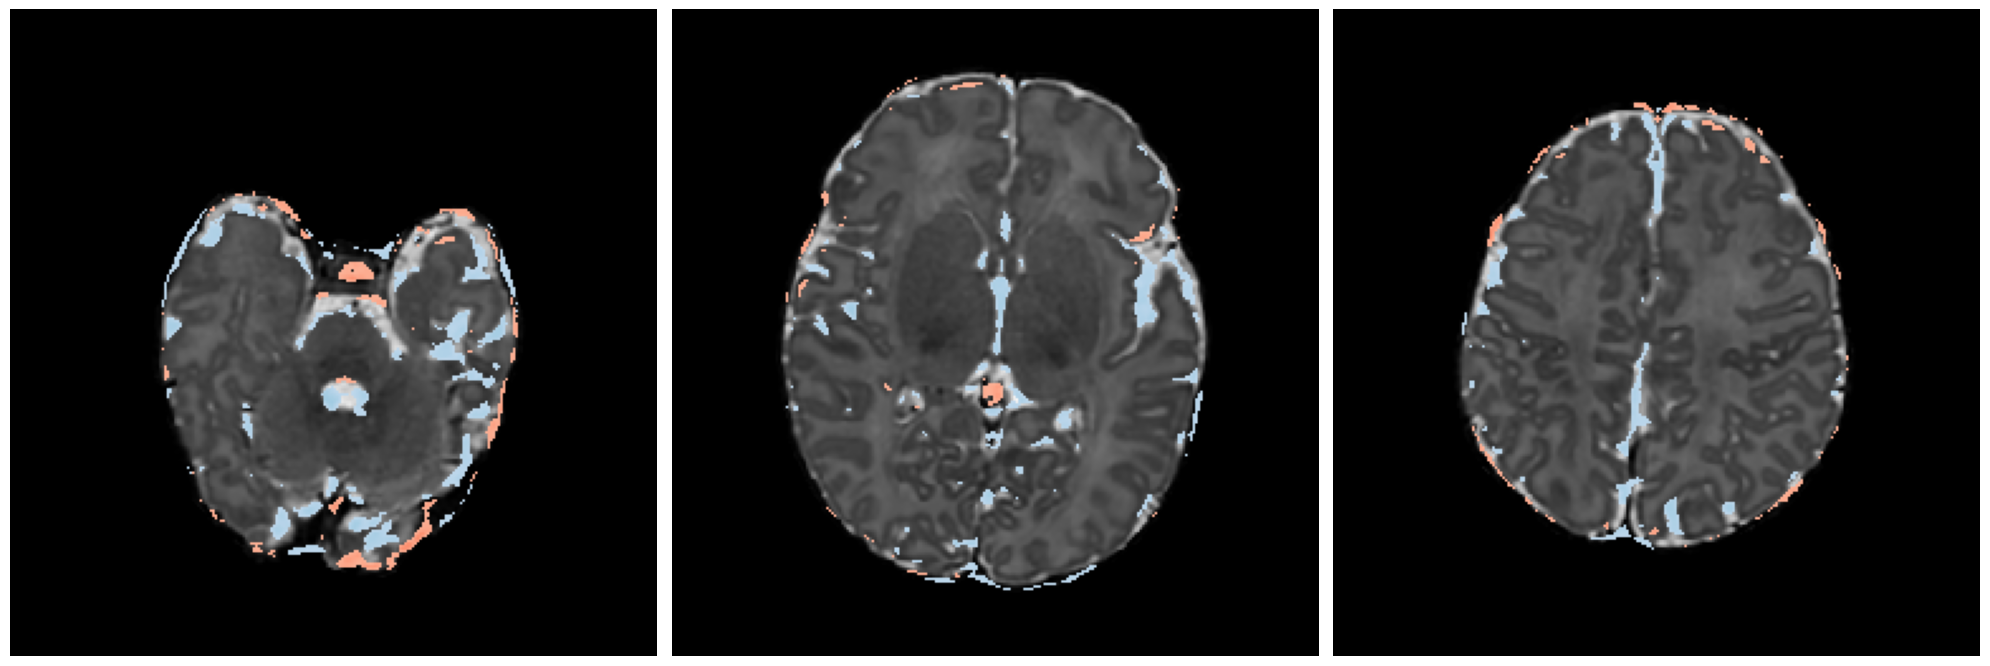

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].imshow(get_slice(t2, norm, 64)) 
ax[1].imshow(get_slice(t2, norm, 128))
ax[2].imshow(get_slice(t2, norm, 192))

for v in ax:
    v.axis('off')
    
fig.tight_layout()

## For Multimodal

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

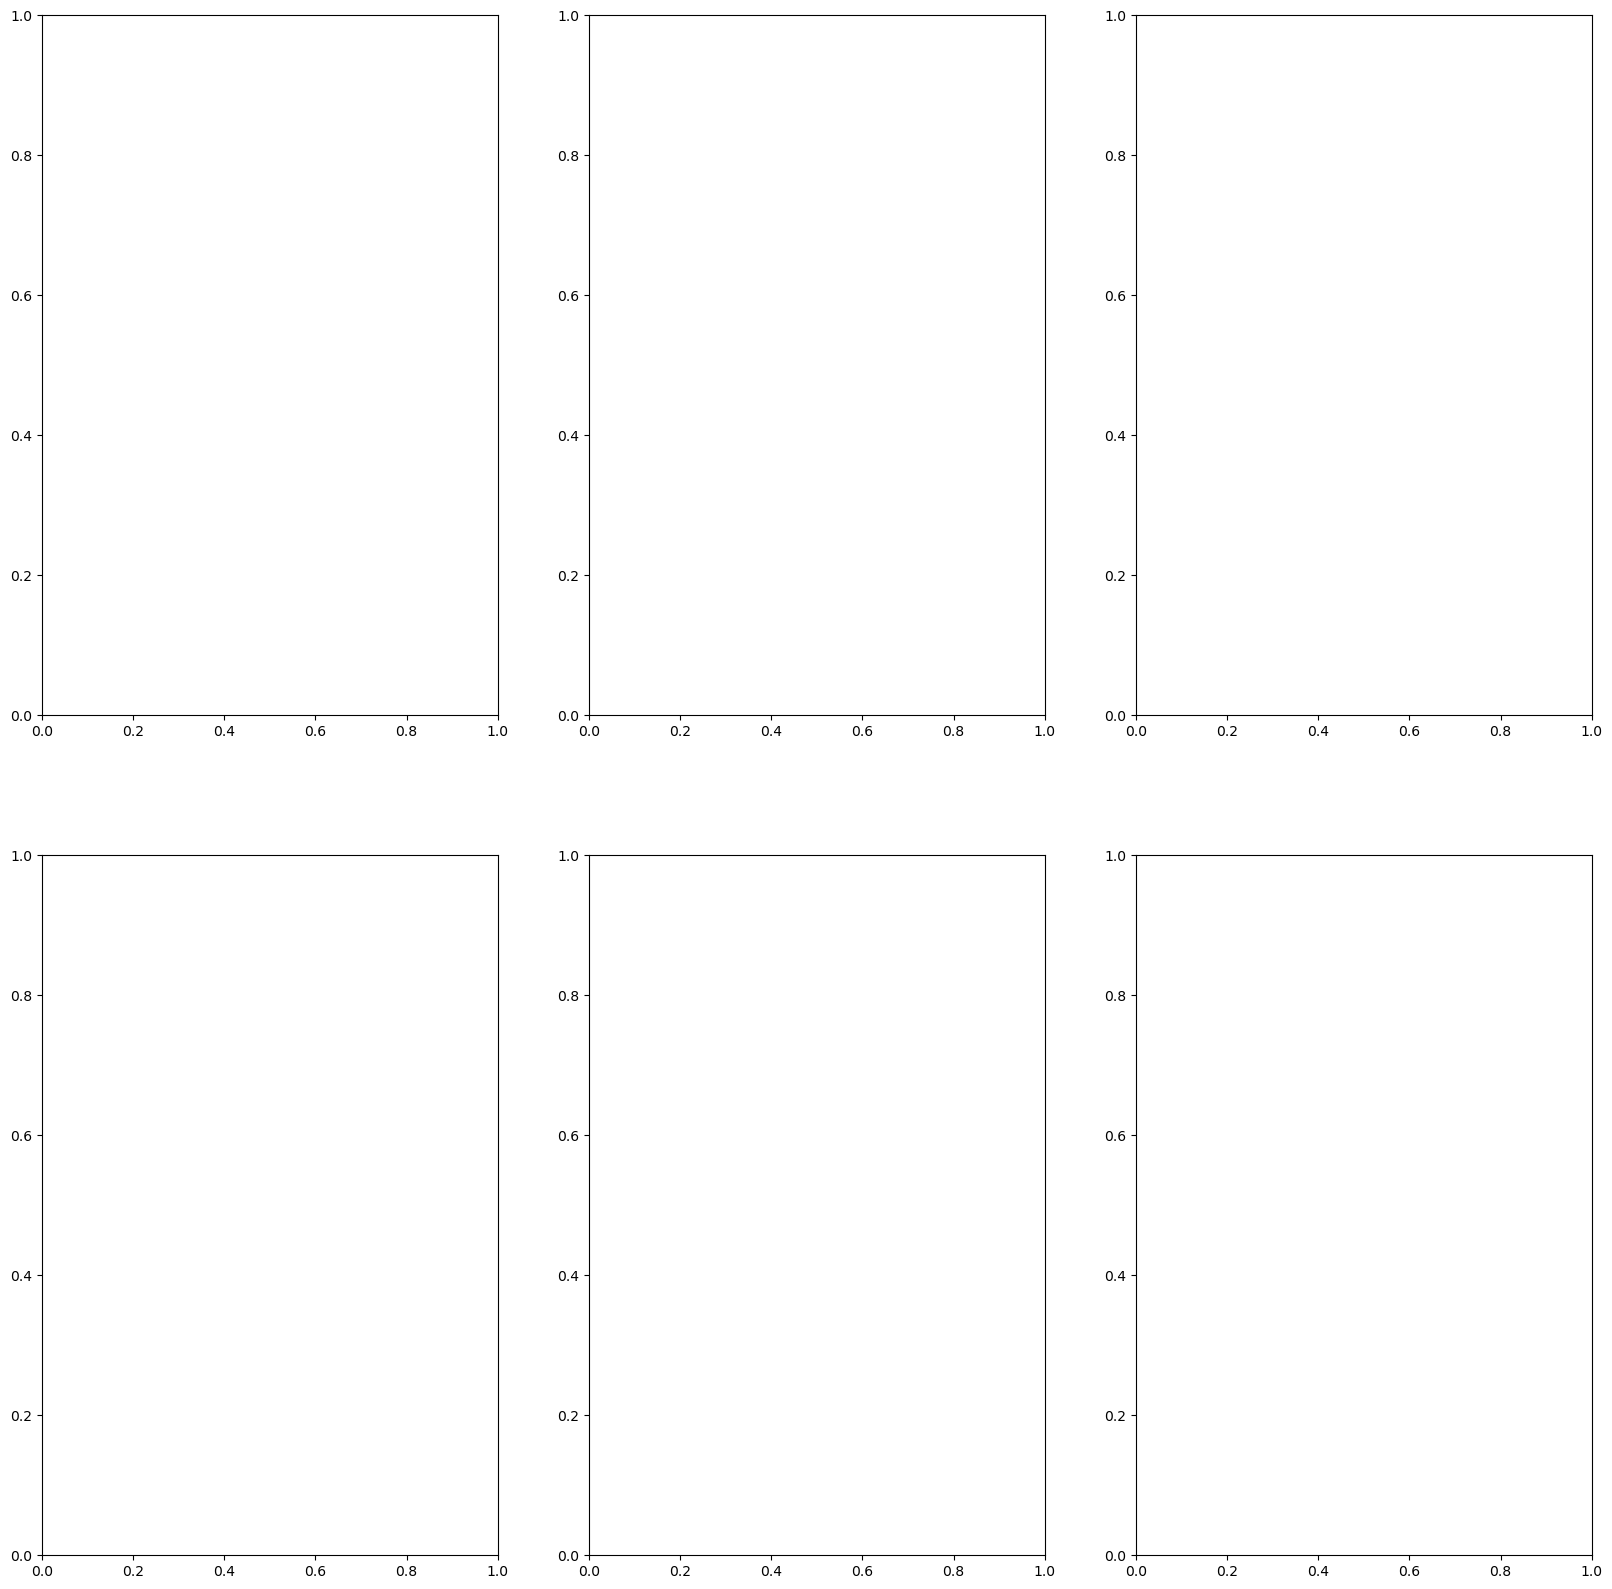

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

ax[0][0].imshow(get_slice(t1, norm[0], 64)) 
ax[0][1].imshow(get_slice(t1, norm[0], 128))
ax[0][2].imshow(get_slice(t1, norm[0], 192))

ax[1][0].imshow(get_slice(t2, norm[1], 64)) 
ax[1][1].imshow(get_slice(t2, norm[1], 128))
ax[1][2].imshow(get_slice(t2, norm[1], 192))

for v in ax:
    for q in v:
        q.axis('off')
    
fig.tight_layout()